## KNN

In dit notebook wordt een KNN model gefit op de metadata zonder tekst. In het script cleanup.ipynb zijn verschillende csv bestanden gemaakt die verschillende groepen metadata bevatten. In dit script worden deze afzonderlijke csv's gebruikt om te kijken hoe de prestaties onderling verschillen.

Vervolgens worden de csv's uit feature_selection.ipynb gebruikt om mee te vergelijken. Deze csv's bevatten minder features omdat er op basis van de analyses in feature_selection.ipynb variabelen verwijderd zijn. 

In [2]:
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

from sklearn.neighbors import KNeighborsClassifier

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, make_scorer, precision_score, recall_score, classification_report
from sklearn.inspection import permutation_importance

In [2]:

all_data = pd.read_csv('../../data/cleaned_data/all_columns.csv')

In [3]:
# should only contain metadata columns, texts are not part of them
all_data = all_data.drop(['Unnamed: 0', 'full_text', 'user_description', 'username'], axis = 1)

In [2]:
def RandomSearchKNN(data):
    """Splits the data into x_train, x_test, y_train, y_test, performs a randomsearch on KNN and calculates the accuracy score using
       the best parameters."""
       
    # select x and y from data
    y = data.pop('real_fake_grade')
    x = data

    # scale variables
    x = StandardScaler().fit_transform(x)

    # split into train and test
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42, stratify=y)

    # perform Random Search with 7-fold CV and scoring on accuracy
    knn_rs = RandomizedSearchCV(KNeighborsClassifier(), 
                          param_distributions = {'weights': ['uniform', 'distance'], 'n_neighbors': [5,10,15]},
                          cv = 7,
                          scoring = make_scorer(accuracy_score)) 

    # fit the model
    knn_rs.fit(x_train, y_train)
    print('Best parameters:\n', knn_rs.best_params_)
    print()

    # make prediction with best parameters
    y_pred = knn_rs.best_estimator_.predict(x_test)

     # calculate accuracy score, precision and recall
    print('Accuracy score:', accuracy_score(y_test, y_pred))
    print('precision score:', precision_score(y_test, y_pred, average = 'macro')) # unweighted mean of all classes
    print('recall score:', recall_score(y_test, y_pred, average = 'macro')) # unweighted mean of all classes

    # classification report
    report = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    print(report_df)

#### All metadata columns

In [ ]:

all_data = pd.read_csv('../../data/cleaned_data/all_columns.csv')

In [ ]:
# should only contain metadata columns, texts are not part of them
all_data = all_data.drop(['Unnamed: 0', 'full_text', 'user_description', 'username'], axis = 1)

In [5]:
RandomSearchKNN(all_data)

Best paramaters:
 {'weights': 'distance', 'n_neighbors': 15}

Accuracy score: 0.6881720430107527


#### Tweet data

In [6]:
tweet_data = pd.read_csv('../../data/cleaned_data/tweet_data_columns.csv')

In [8]:
tweet_data = tweet_data.drop('Unnamed: 0', axis = 1)

In [9]:
RandomSearchKNN(tweet_data)

Best paramaters:
 {'weights': 'distance', 'n_neighbors': 15}

Accuracy score: 0.6394686907020873


### User Data

In [10]:
user_data = pd.read_csv('../../data/cleaned_data/user_data_columns.csv')
user_data = user_data.drop('Unnamed: 0', axis = 1)

In [11]:
RandomSearchKNN(user_data)

Best paramaters:
 {'weights': 'distance', 'n_neighbors': 15}

Accuracy score: 0.7020872865275142


## Resultaten op data met feature selection

De datasets die hieronder gebruikt worden zijn afkomstig van het script feature_selection.ipynb.

#### All data selected

In [3]:
all_data_selected = pd.read_csv('../../data/selected_data/all_data_selected.csv')
all_data_selected = all_data_selected.drop([ 'Unnamed: 0', 'full_text', 'user_description', 'username'], axis = 1)
RandomSearchKNN(all_data_selected)

Best parameters:
 {'weights': 'distance', 'n_neighbors': 15}

Accuracy score: 0.6888045540796964
precision score: 0.5816076416270174
recall score: 0.5023909402272569
              precision    recall  f1-score      support
-1.0           0.640394  0.552017  0.592930   471.000000
0.0            0.388889  0.076923  0.128440   182.000000
1.0            0.715540  0.878233  0.788582   928.000000
accuracy       0.688805  0.688805  0.688805     0.688805
macro avg      0.581608  0.502391  0.503318  1581.000000
weighted avg   0.655550  0.688805  0.654302  1581.000000


#### Permutation importance all data selected

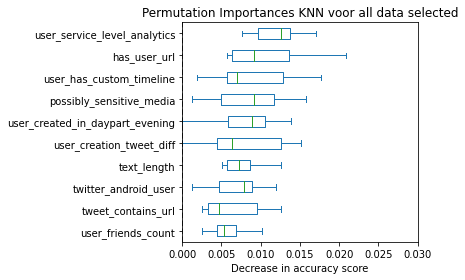

In [5]:
all_data_selected = pd.read_csv('../../data/selected_data/all_data_selected.csv')
all_data_selected = all_data_selected.drop([ 'Unnamed: 0', 'full_text', 'user_description', 'username'], axis = 1)

# select x and y from data
y = all_data_selected.pop('real_fake_grade')
x = all_data_selected
x = StandardScaler().fit_transform(x)

# split into train and test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42, stratify=y)

model = KNeighborsClassifier(weights='distance', n_neighbors=15).fit(x_train, y_train) # zelfde parameter waarden als uit _best_params_ van randomsearch

result = permutation_importance(
    model, x_test, y_test, n_repeats=10, random_state=42, n_jobs=2,
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=all_data_selected.columns[sorted_importances_idx],
)


importances = importances.iloc[:,30:]

ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances KNN voor all data selected")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()
plt.xlim(0,0.03)

plt.show()

#### Tweet data selected

In [4]:
tweet_data_selected = pd.read_csv('../../data/selected_data/tweet_data_selected.csv')
RandomSearchKNN(tweet_data_selected)


Best parameters:
 {'weights': 'distance', 'n_neighbors': 15}

Accuracy score: 0.6552814674256799
precision score: 0.5350358227079538
recall score: 0.48952014457587706
              precision    recall  f1-score      support
-1.0           0.620219  0.481953  0.542413   471.000000
0.0            0.288889  0.142857  0.191176   182.000000
1.0            0.696000  0.843750  0.762786   928.000000
accuracy       0.655281  0.655281  0.655281     0.655281
macro avg      0.535036  0.489520  0.498792  1581.000000
weighted avg   0.626558  0.655281  0.631332  1581.000000


#### User data selected


In [5]:
user_data_selected = pd.read_csv('../../data/selected_data/user_data_selected.csv')
RandomSearchKNN(user_data_selected)


Best parameters:
 {'weights': 'distance', 'n_neighbors': 15}

Accuracy score: 0.7052498418722327
precision score: 0.5975206854673973
recall score: 0.5534525348178434
              precision    recall  f1-score     support
-1.0           0.716749  0.617834  0.663626   471.00000
0.0            0.339806  0.192308  0.245614   182.00000
1.0            0.736007  0.850216  0.789000   928.00000
accuracy       0.705250  0.705250  0.705250     0.70525
macro avg      0.597521  0.553453  0.566080  1581.00000
weighted avg   0.684661  0.705250  0.689097  1581.00000
